In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Loading

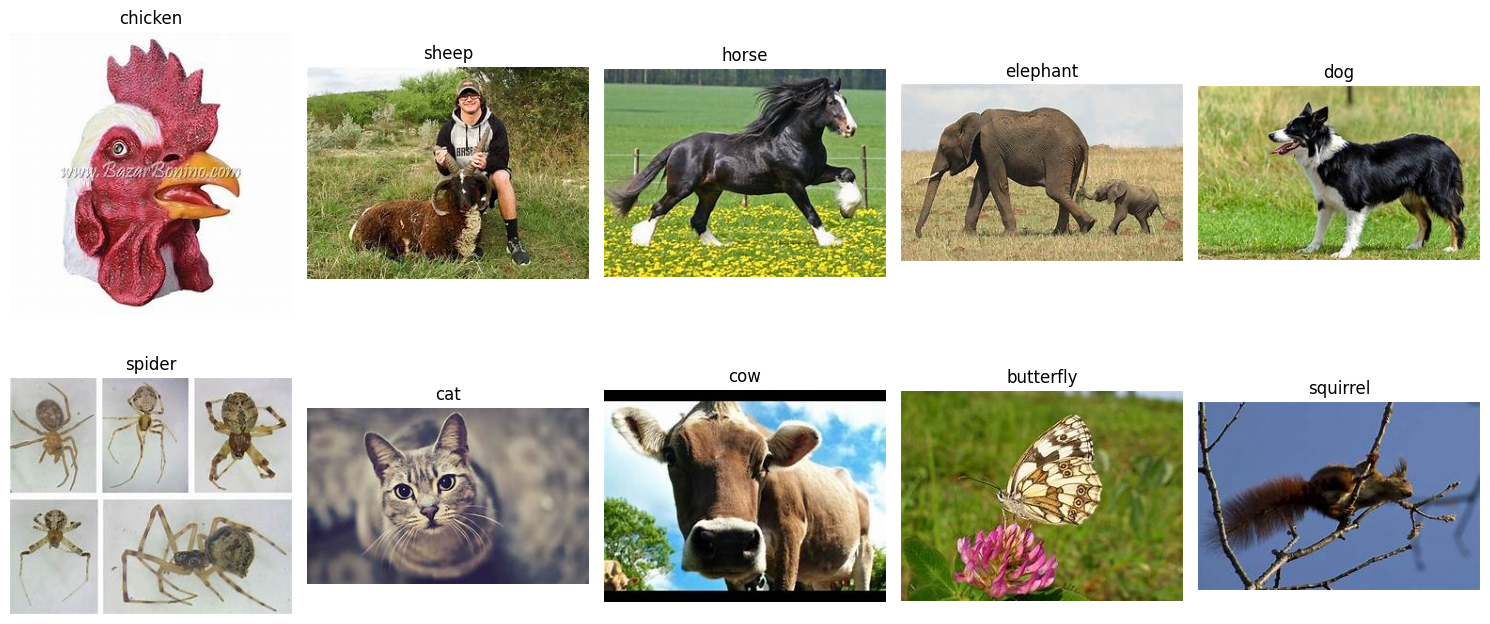

In [4]:
import os
from IPython.display import display, Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

folder_dir = "/content/drive/MyDrive/animal_subset/train"

fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.flatten()
idx = 0

for folder_name in os.listdir(folder_dir):
    sub_path = os.path.join(folder_dir, folder_name)
    if os.path.isdir(sub_path) and idx < 10:
        for f in os.listdir(sub_path):
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                img = mpimg.imread(os.path.join(sub_path, f))
                axes[idx].imshow(img)
                axes[idx].set_title(folder_name)
                axes[idx].axis('off')
                idx += 1
                break

plt.tight_layout()
plt.show()

# Pre-processing and Pre-trained Model

In [5]:
from PIL import Image
import numpy as np

# Load an image
img = Image.open('/content/drive/MyDrive/animal_subset/train/chicken/OIP-17-lGSVXlvBXO_oYZzkY9QHaFi.jpeg')

# Resize to target size
img = img.resize((224, 224))

# Convert to numpy array
x = np.array(img)
print(x.shape)  # (224, 224, 3)

(224, 224, 3)


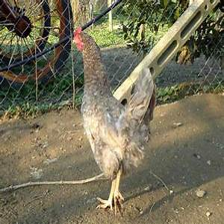

In [6]:
img

In [7]:
import torch
import torchvision.models as models
from torchvision import transforms
import numpy as np

# Load pre-trained model
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.eval()

# Preprocessing for MobileNetV2
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
img = Image.open('/content/drive/MyDrive/animal_subset/train/chicken/OIP-17-lGSVXlvBXO_oYZzkY9QHaFi.jpeg')
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

# Make prediction
with torch.no_grad():
    output = model(batch_t)

# Get top predictions
_, indices = torch.sort(output, descending=True)

In [9]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

# Load ImageNet class names
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Get top 5 predictions
top5_indices = indices[0, :5].tolist()
top5_classes = [categories[i] for i in top5_indices]

print("Top 5 predictions:")
for i, class_name in enumerate(top5_classes):
    print(f"{i+1}: {class_name}")

--2026-01-03 17:54:55--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2026-01-03 17:54:55 (139 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]

Top 5 predictions:
1: hen
2: cock
3: partridge
4: llama
5: hare


It predict the specific breed of dog

# Train Model

In [10]:
import os
from torch.utils.data import Dataset
from PIL import Image

class AnimalDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
from torchvision import transforms

input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [14]:
from torch.utils.data import DataLoader

train_dataset = AnimalDataset(
    data_dir='/content/drive/MyDrive/animal_subset/train',
    transform=train_transforms
)

val_dataset = AnimalDataset(
    data_dir='/content/drive/MyDrive/animal_subset/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [24]:
import torch.nn as nn
import torchvision.models as models

class AnimalClassifierMobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AnimalClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

In [25]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AnimalClassifierMobileNet(num_classes=10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [26]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/10
  Train Loss: 2.9337, Train Acc: 0.2100
  Val Loss: 2.2341, Val Acc: 0.5600
Epoch 2/10
  Train Loss: 2.6663, Train Acc: 0.6200
  Val Loss: 1.3980, Val Acc: 0.6900
Epoch 3/10
  Train Loss: 0.9499, Train Acc: 0.7500
  Val Loss: 0.7102, Val Acc: 0.7600
Epoch 4/10
  Train Loss: 0.9707, Train Acc: 0.8400
  Val Loss: 1.3815, Val Acc: 0.6100
Epoch 5/10
  Train Loss: 1.0284, Train Acc: 0.8300
  Val Loss: 0.8306, Val Acc: 0.6500
Epoch 6/10
  Train Loss: 0.5911, Train Acc: 0.8900
  Val Loss: 0.4913, Val Acc: 0.8200
Epoch 7/10
  Train Loss: 0.5271, Train Acc: 0.9500
  Val Loss: 1.3154, Val Acc: 0.7400
Epoch 8/10
  Train Loss: 0.8752, Train Acc: 0.8800
  Val Loss: 1.0514, Val Acc: 0.7700
Epoch 9/10
  Train Loss: 0.0843, Train Acc: 0.9800
  Val Loss: 0.7258, Val Acc: 0.7600
Epoch 10/10
  Train Loss: 0.1771, Train Acc: 0.9600
  Val Loss: 0.7007, Val Acc: 0.7900


In [27]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Tuning

In [28]:
def make_model(learning_rate=0.01):
    model = AnimalClassifierMobileNet(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [31]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

for lr in learning_rates:
    print(f'\n=== Learning Rate: {lr} ===')
    model, optimizer = make_model(learning_rate=lr)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Learning Rate: 0.0001 ===
Epoch 1/10
  Train Loss: 2.4221, Train Acc: 0.0400
  Val Loss: 2.3831, Val Acc: 0.0600
Epoch 2/10
  Train Loss: 2.3153, Train Acc: 0.0300
  Val Loss: 2.3429, Val Acc: 0.0500
Epoch 3/10
  Train Loss: 2.2040, Train Acc: 0.1300
  Val Loss: 2.2903, Val Acc: 0.0900
Epoch 4/10
  Train Loss: 2.2161, Train Acc: 0.1300
  Val Loss: 2.2518, Val Acc: 0.1100
Epoch 5/10
  Train Loss: 2.1515, Train Acc: 0.2100
  Val Loss: 2.2215, Val Acc: 0.1100
Epoch 6/10
  Train Loss: 2.1612, Train Acc: 0.2200
  Val Loss: 2.1854, Val Acc: 0.1600
Epoch 7/10
  Train Loss: 2.1073, Train Acc: 0.2500
  Val Loss: 2.1514, Val Acc: 0.1800
Epoch 8/10
  Train Loss: 2.0763, Train Acc: 0.3100
  Val Loss: 2.1141, Val Acc: 0.2300
Epoch 9/10
  Train Loss: 2.0216, Train Acc: 0.3500
  Val Loss: 2.0945, Val Acc: 0.2400
Epoch 10/10
  Train Loss: 2.0321, Train Acc: 0.4000
  Val Loss: 2.0645, Val Acc: 0.2700

=== Learning Rate: 0.001 ===
Epoch 1/10
  Train Loss: 2.3474, Train Acc: 0.1500
  Val Loss: 2.077

So the best learning rate is 0.001

In [36]:
class AnimalClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, num_classes=10):
        super(AnimalClassifierMobileNet, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        for param in self.base_model.parameters():
            param.requires_grad = False

        self.base_model.classifier = nn.Identity()

        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)  # New inner layer
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

def make_model(learning_rate=0.001, size_inner=100):
    model = AnimalClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [37]:
size_inner = [10, 100, 1000]

for size_inner in size_inner:
    print(f'\n=== Size Inner: {size_inner} ===')
    model, optimizer = make_model(learning_rate=0.001, size_inner=size_inner)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Size Inner: 10 ===
Epoch 1/10
  Train Loss: 2.2776, Train Acc: 0.1400
  Val Loss: 2.3842, Val Acc: 0.1200
Epoch 2/10
  Train Loss: 2.2265, Train Acc: 0.2500
  Val Loss: 2.3301, Val Acc: 0.2100
Epoch 3/10
  Train Loss: 2.1534, Train Acc: 0.2700
  Val Loss: 2.2613, Val Acc: 0.2700
Epoch 4/10
  Train Loss: 2.1266, Train Acc: 0.3300
  Val Loss: 2.1829, Val Acc: 0.2800
Epoch 5/10
  Train Loss: 1.9796, Train Acc: 0.3100
  Val Loss: 2.1317, Val Acc: 0.3100
Epoch 6/10
  Train Loss: 1.8347, Train Acc: 0.4100
  Val Loss: 2.1106, Val Acc: 0.3500
Epoch 7/10
  Train Loss: 1.9801, Train Acc: 0.4300
  Val Loss: 2.0801, Val Acc: 0.3300
Epoch 8/10
  Train Loss: 1.8017, Train Acc: 0.4400
  Val Loss: 1.9887, Val Acc: 0.3500
Epoch 9/10
  Train Loss: 1.7738, Train Acc: 0.4500
  Val Loss: 1.9457, Val Acc: 0.4200
Epoch 10/10
  Train Loss: 1.7066, Train Acc: 0.5200
  Val Loss: 1.8664, Val Acc: 0.4500

=== Size Inner: 100 ===
Epoch 1/10
  Train Loss: 2.3320, Train Acc: 0.1800
  Val Loss: 1.9919, Val Acc: 

Best Size inner: 100

In [38]:
class AnimalClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(AnimalClassifierMobileNet, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        for param in self.base_model.parameters():
            param.requires_grad = False

        self.base_model.classifier = nn.Identity()

        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x

def make_model(
        learning_rate=0.001,
        size_inner=100,
        droprate=0.2
):
    model = AnimalClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner,
        droprate=droprate
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [39]:
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(f'\n=== Drop Rate: {droprate} ===')
    model, optimizer = make_model(learning_rate=0.001, size_inner=100, droprate=droprate)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Drop Rate: 0.0 ===
Epoch 1/10
  Train Loss: 2.2158, Train Acc: 0.2100
  Val Loss: 1.9837, Val Acc: 0.4600
Epoch 2/10
  Train Loss: 1.8030, Train Acc: 0.5000
  Val Loss: 1.6999, Val Acc: 0.4400
Epoch 3/10
  Train Loss: 1.5275, Train Acc: 0.6800
  Val Loss: 1.2854, Val Acc: 0.7200
Epoch 4/10
  Train Loss: 1.2603, Train Acc: 0.8700
  Val Loss: 1.0227, Val Acc: 0.6500
Epoch 5/10
  Train Loss: 1.1222, Train Acc: 0.9200
  Val Loss: 0.9310, Val Acc: 0.8300
Epoch 6/10
  Train Loss: 0.8303, Train Acc: 0.9300
  Val Loss: 1.0602, Val Acc: 0.6900
Epoch 7/10
  Train Loss: 0.5897, Train Acc: 0.9400
  Val Loss: 0.9157, Val Acc: 0.8000
Epoch 8/10
  Train Loss: 0.4935, Train Acc: 0.9500
  Val Loss: 0.7292, Val Acc: 0.8400
Epoch 9/10
  Train Loss: 0.4111, Train Acc: 0.9700
  Val Loss: 0.5758, Val Acc: 0.8200
Epoch 10/10
  Train Loss: 0.5910, Train Acc: 0.9700
  Val Loss: 0.5041, Val Acc: 0.8300

=== Drop Rate: 0.2 ===
Epoch 1/10
  Train Loss: 2.2814, Train Acc: 0.1300
  Val Loss: 2.0509, Val Acc: 0

The model works best without dropout or dropout = 0

In [40]:
class AnimalClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.0, num_classes=10):
        super(AnimalClassifierMobileNet, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        for param in self.base_model.parameters():
            param.requires_grad = False

        self.base_model.classifier = nn.Identity()

        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x

def make_model(
        learning_rate=0.001,
        size_inner=100,
        droprate=0.0
):
    model = AnimalClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner,
        droprate=droprate
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [41]:
def train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy

    # exising code
    # Checkpoint the model if validation accuracy improved
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        checkpoint_path = f'mobilenet_v2_{epoch+1:02d}_{val_acc:.3f}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')

In [44]:
model, optimizer = make_model(learning_rate=0.001, size_inner=100, droprate=0.0)

train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Checkpoint saved: mobilenet_v2_10_0.790.pth


In [45]:
# Training transforms WITH augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Validation transforms - NO augmentation, same as before
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [46]:
import glob

# Find best checkpoint
list_of_files = glob.glob('mobilenet_v2_*.pth')
latest_file = max(list_of_files, key=os.path.getctime)
print(f"Loading model from: {latest_file}")

# Load model
model = AnimalClassifierMobileNet(num_classes=10)
model.load_state_dict(torch.load(latest_file))
model.to(device)
model.eval()

Loading model from: mobilenet_v2_10_0.790.pth


AnimalClassifierMobileNet(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 9

In [56]:
from keras_image_helper import create_preprocessor
import numpy as np

def preprocess_pytorch_style(X):
    # X: shape (1, 224, 224, 3), dtype=float32, values in [0, 255]
    X = X / 255.0

    mean = np.array([[[[0.485]],

        [[0.456]],

        [[0.406]]]])
    std = np.array([[[[0.229]],

        [[0.224]],

        [[0.225]]]])

    # Convert NHWC → NCHW (batch, height, width, channels → batch, channels, height, width)
    X = X.transpose(0, 3, 1, 2)

    # Normalize
    X = (X - mean) / std

    return X.astype(np.float32)

preprocessor = create_preprocessor(preprocess_pytorch_style, target_size=(224, 224))

# Predict from URL
url = 'https://cataas.com/cat'
X = preprocessor.from_url(url)
X = torch.Tensor(X).to(device)

with torch.no_grad():
    pred = model(X).cpu().numpy()[0]

classes = [
    "butterfly", "cat", "chicken", "cow", "dog",
    "elephant", "horse", "sheep", "spider", "squirrel"
]

result = dict(zip(classes, pred.tolist()))
print(result)

{'butterfly': -0.14544729888439178, 'cat': 0.2953532934188843, 'chicken': 0.14183855056762695, 'cow': 0.04649144038558006, 'dog': -0.025070324540138245, 'elephant': -0.06549744307994843, 'horse': -0.0913924127817154, 'sheep': 0.17320364713668823, 'spider': -0.02541351318359375, 'squirrel': 0.2633916437625885}


In [61]:
import onnxscript
# Create dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = "animal_classifier_mobilenet_v2.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print(f"Model exported to {onnx_path}")

/tmp/ipython-input-2024521850.py:8: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `AnimalClassifierMobileNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `AnimalClassifierMobileNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 105 of general pattern rewrite rules.
Model exported to animal_classifier_mobilenet_v2.onnx
